<a href="https://colab.research.google.com/github/LinggarM/Transformers-1.0/blob/master/Transformers_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
pip install transformers

     |████████████████████████████████| 3.8 MB 5.0 MB/s 
     |████████████████████████████████| 6.5 MB 47.1 MB/s 
     |████████████████████████████████| 596 kB 32.5 MB/s 
     |████████████████████████████████| 67 kB 4.2 MB/s 
     |████████████████████████████████| 895 kB 60.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf
from keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Flatten, Dense, Dropout, Activation, Lambda
from keras.layers.merge import concatenate
import math

# Data Preparation

## Import Dummy Data (Ukara Dataset)
[https://github.com/aliakbars/ukara](https://github.com/aliakbars/ukara)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
path = "/content/gdrive/MyDrive/Upload/Machine Learning/Projects/Transformers 1.0/Data/Dummy Data"
data_dev = f"{path}/Data A/data_dev_A.csv"
data_train = f"{path}/Data A/data_train_A.csv"

In [5]:
df_dev = pd.read_csv(data_dev)
df_train = pd.read_csv(data_train)

In [6]:
df_train.head()

,RES_ID,RESPONSE,LABEL
0,TRA1,intetraksi/beradaptasi terhadap lingkungan yan...,1
1,TRA2,seperti jatuhnya meteor tsunami gempa bumi,0
2,TRA3,hanya tuhan yang tahu tantangan nya itu apaan,0
3,TRA4,mereka akan sulit beradaptasi,1
4,TRA5,"Tempat tinggal, ekonomi, dan pekerjaan",1


In [7]:
df_dev.head()

,RES_ID,RESPONSE
0,DEVA1,karena di tempat tnggalnya tidak aman karena b...
1,DEVA2,"banyak yang menolak, susah mencari lapangan pe..."
2,DEVA3,ah berkomunikasi dengan wilyah yang mereka tem...
3,DEVA4,"tantangan yang akan mereka hadapi, seperti mer..."
4,DEVA5,Mereka akan tidak terbiasa dengan tempat baru


## Process Data

**Stimulus** : Pemanasan global terjadi karena peningkatan produksi karbon dioksida yang dihasilkan oleh pembakaran fosil dan konsumsi bahan bakar yang tinggi. Salah satu akibat adalah mencairnya es abadi di kutub utara dan selatan yang menimbulkan naiknya ketinggian air laut. kenaikan air laut akan terjadi terus menerus meskipun dalam hitungan centimeter akan mengakibatkan perubahan yang signifikan. Film “Waterworld”, adalah film fiksi ilmiah yang menunjukkan akibat adanya pemanasan global yang sangat besar sehingga menyebabkan bumi menjadi tertutup oleh lautan. Negara-negara dan daratan yang dulunya kering menjadi tengelamn karena terjadi kenaikan permukaan air laut. Penduduk yang dulunya bisa berkehidupan bebas menjadi terpaksa mengungsi ke daratan yang lebih tinggi atau tinggal diatas air.

**Pertanyaan** : Apa yang akan menjadi tantangan bagi suatu penduduk ketika terjadi situasi daratan tidak dapat ditinggali kembali karena tengelam oleh naiknya air laut?

In [8]:
# question initialization
stimulus = "Pemanasan global terjadi karena peningkatan produksi karbon dioksida yang dihasilkan oleh pembakaran fosil dan konsumsi bahan bakar yang tinggi. Salah satu akibat adalah mencairnya es abadi di kutub utara dan selatan yang menimbulkan naiknya ketinggian air laut. kenaikan air laut akan terjadi terus menerus meskipun dalam hitungan centimeter akan mengakibatkan perubahan yang signifikan. Film “Waterworld”, adalah film fiksi ilmiah yang menunjukkan akibat adanya pemanasan global yang sangat besar sehingga menyebabkan bumi menjadi tertutup oleh lautan. Negara-negara dan daratan yang dulunya kering menjadi tengelamn karena terjadi kenaikan permukaan air laut. Penduduk yang dulunya bisa berkehidupan bebas menjadi terpaksa mengungsi ke daratan yang lebih tinggi atau tinggal diatas air."
pertanyaan = "Apa yang akan menjadi tantangan bagi suatu penduduk ketika terjadi situasi daratan tidak dapat ditinggali kembali karena tengelam oleh naiknya air laut?"

In [9]:
# get answers data
jawaban_train = df_train['RESPONSE'].tolist()
jawaban_dev = df_dev['RESPONSE'].tolist()
data_jawaban = jawaban_train + jawaban_dev

In [10]:
# get answers data length
data_len = len(data_jawaban)

In [11]:
# set id_mahasiswa
id_mahasiswa = np.arange(data_len)

In [12]:
# create dataframe for dummy data
df_dummy = pd.DataFrame({'id_mahasiswa': id_mahasiswa, 'jawaban': data_jawaban})
df_dummy.head()

,id_mahasiswa,jawaban
0,0,intetraksi/beradaptasi terhadap lingkungan yan...
1,1,seperti jatuhnya meteor tsunami gempa bumi
2,2,hanya tuhan yang tahu tantangan nya itu apaan
3,3,mereka akan sulit beradaptasi
4,4,"Tempat tinggal, ekonomi, dan pekerjaan"


In [13]:
# get data (question, id, answers, and data length)
question = pertanyaan
id_answers = df_dummy['id_mahasiswa'].tolist()
answers = df_dummy['jawaban'].tolist()
total_answers = len(df_dummy)

In [14]:
# data limitation
max_data = 50
id_answers = id_answers[:max_data]
answers = answers[:max_data]
total_answers = max_data

# Encode Data (Pertanyaan & Jawaban)

## IndoBERT

### Import Model & Tokenizer

In [15]:
from transformers import BertTokenizer, AutoModel
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

### Data Preprocessing (Tokenization, Padding, Vectorization)

#### Answers

In [16]:
encoded_answers = tokenizer(answers, padding= True, return_tensors="pt")

In [17]:
print(encoded_answers['input_ids'])

tensor([[    2,  1666, 15261,  ...,     0,     0,     0],
        [    2,   295, 16300,  ...,     0,     0,     0],
        [    2,   344,  1251,  ...,     0,     0,     0],
        ...,
        [    2,   267,   308,  ...,     0,     0,     0],
        [    2,   599,   119,  ...,     0,     0,     0],
        [    2,  8635,   224,  ...,     0,     0,     0]])


#### Question

In [18]:
# get answer encoding length
question_enc_len = len(encoded_answers['input_ids'][0])

In [19]:
encoded_question = tokenizer(question, max_length = question_enc_len, padding= 'max_length', return_tensors='pt')

In [20]:
print(encoded_question['input_ids'])

tensor([[    2,   387,    34,   150,   234,  4776,   396,   607,  2317,   640,
           597,  3461,  9840,   119,   173,  7378, 30356,   755,   211,  9390,
          8893,   213, 17486,   514,  1784, 30477,     3,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])


### Embedding

#### Hidden States of Last Layer

##### Question

In [21]:
embedded_question = model(torch.LongTensor(encoded_question['input_ids']).view(1,-1))

In [22]:
# get 'last_hidden_state' vector dimension
print(embedded_question['last_hidden_state'].shape)

torch.Size([1, 41, 768])


In [23]:
print(embedded_question['last_hidden_state'])

tensor([[[ 1.3860,  1.6921,  1.2233,  ..., -0.3143, -0.0187,  0.6325],
         [ 0.8425, -0.4155,  0.2525,  ..., -0.1358, -1.1921,  1.1689],
         [ 0.6814,  0.7837, -0.1358,  ...,  0.3423, -0.9431,  1.4636],
         ...,
         [-0.5308,  0.2529,  0.9454,  ...,  0.2480, -0.6178, -0.1041],
         [-0.3763,  0.1834,  1.3085,  ..., -0.0104, -0.3863, -0.1750],
         [-0.0542, -0.2274,  1.3209,  ...,  0.0991, -0.4381,  0.1323]]],
       grad_fn=<NativeLayerNormBackward0>)


##### Answers

In [24]:
embedded_answers = []
for i in range(total_answers) :
  x = torch.LongTensor(encoded_answers['input_ids'][i]).view(1,-1)
  x = model(x)
  embedded_answers.append(x)

In [25]:
# get 'last_hidden_state' vector dimension
print((embedded_answers[0]['last_hidden_state']).shape)

torch.Size([1, 41, 768])


##### Convert to Numpy

In [26]:
# question
embedded_question_np = embedded_question['last_hidden_state'].detach().numpy()

# answers
embedded_answers_np = []
for i in range(total_answers) :
  embedded_answers_np.append(embedded_answers[i]['last_hidden_state'].detach().numpy())
embedded_answers_np = np.array(embedded_answers_np)

#### Pooler Output

##### Question

In [177]:
embedded_question = model(torch.LongTensor(encoded_question['input_ids']).view(1,-1))

In [178]:
# get 'pooler_output' vector dimension
print(embedded_question['pooler_output'].shape)

torch.Size([1, 768])


In [179]:
print(embedded_question['pooler_output'])

tensor([[-8.9305e-01, -7.7686e-01,  5.2353e-01, -5.4589e-01,  5.9358e-01,
         -7.1775e-01,  3.7165e-01,  9.0938e-01, -5.5386e-04, -8.6047e-01,
          3.3001e-01,  6.6988e-01,  3.5002e-01,  6.6479e-01,  8.7926e-01,
         -9.1604e-01,  3.8805e-02, -1.0995e-01,  8.4388e-01,  7.0028e-01,
         -7.0506e-01,  6.0252e-01,  8.3928e-01, -8.3211e-01, -1.0464e-01,
         -5.3500e-01,  2.6318e-01,  8.3104e-01,  1.5647e-01, -3.4170e-01,
         -2.9505e-01,  5.3875e-01, -2.1231e-01, -6.3753e-01,  8.8623e-01,
         -9.0209e-01,  8.4677e-01,  6.0883e-02, -5.1492e-01, -5.1269e-01,
          1.8695e-01, -8.0960e-01,  8.1334e-01,  9.0090e-01,  8.8360e-01,
          5.5761e-01,  4.9139e-01, -3.9371e-01,  7.1489e-02, -7.4445e-01,
          9.7926e-01, -3.7803e-01, -7.3009e-01, -2.4109e-01,  3.0518e-01,
          4.1121e-01, -4.0913e-01,  3.7392e-01, -7.2182e-01,  7.0361e-01,
          5.6318e-01, -2.3905e-01,  7.8189e-01,  3.3995e-01, -2.0529e-01,
         -6.0394e-01, -6.2153e-01, -5.

##### Answers

In [180]:
embedded_answers = []
for i in range(total_answers) :
  x = torch.LongTensor(encoded_answers['input_ids'][i]).view(1,-1)
  x = model(x)
  embedded_answers.append(x)

In [182]:
# get 'pooler_output' vector dimension
print((embedded_answers[0]['pooler_output']).shape)

torch.Size([1, 768])


##### Convert to Numpy

In [183]:
# question
embedded_question_np = embedded_question['pooler_output'].detach().numpy()

# answers
embedded_answers_np = []
for i in range(total_answers) :
  embedded_answers_np.append(embedded_answers[i]['pooler_output'].detach().numpy())
embedded_answers_np = np.array(embedded_answers_np)

#### Others (Last 4 Hidden States, Mean of All Hidden States, and Sum of All Hidden States)
last 4 hidden states get best result from paper https://arxiv.org/pdf/1810.04805.pdf

In [226]:
lastfour_hs_question = torch.cat(tuple([embedded_question['last_hidden_state'][0][i] for i in [-4, -3, -2, -1]]))
lastfour_hs_answers = []
for j in range(total_answers) :
  lastfour_hs_answers.append(torch.cat(tuple([embedded_answers[j]['last_hidden_state'][0][i] for i in [-4, -3, -2, -1]])))

In [219]:
# get vector dimension
lastfour_hs_question.shape

torch.Size([3072])

In [234]:
# question
embedded_question_np = lastfour_hs_question.detach().numpy()

# answers
embedded_answers_np = []
for i in range(total_answers) :
  embedded_answers_np.append(lastfour_hs_answers[i].detach().numpy())
embedded_answers_np = np.array(embedded_answers_np)

In [188]:
# get vector from mean of all hidden states
embeddedquestion_meanhiddenstate = torch.mean(embedded_question['last_hidden_state'][0], dim=0)

In [190]:
# get vector dimension
embeddedquestion_meanhiddenstate.shape

torch.Size([768])

In [ ]:
# get vector from sum of all hidden states
embeddedquestion_sumhiddenstate = torch.sum(embedded_question['last_hidden_state'][0], dim=0)

In [191]:
# get vector dimension
embeddedquestion_sumhiddenstate.shape

torch.Size([768])

## Word2vec

## Glove

## FastText

## TF-IDF

# Measure the Distance

## Define Distance Function

### Cosine Similarity (with Max Pooling)

In [27]:
def maxPooling(x) :
    return K.max(K.constant(x), axis=1, keepdims=False)

# def avgPooling(x) :
#     return K.mean(K.constant(x), axis=1, keepdims=False)

def cosineSimilarity(x, y) :
    normalize_a = tf.nn.l2_normalize(maxPooling(x),0)        
    normalize_b = tf.nn.l2_normalize(maxPooling(y),0)
    cos_similarity = tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
    return cos_similarity

def cosineSimilarityWithoutMaxPooling(x, y) :
    normalize_a = tf.nn.l2_normalize(x,0)        
    normalize_b = tf.nn.l2_normalize(y,0)
    cos_similarity = tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
    return cos_similarity

def cosineSimilarity2(v1,v2):
    """
    More accurate
    compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)
    """
    v1 = maxPooling(v1)
    v2 = maxPooling(v2)
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy)

### Euclidean Distance

In [166]:
# euclidean distance 1D
def euclideanDistance1D(x, y):
    dist = tf.sqrt(tf.reduce_sum(tf.square(x - y)))
    return dist

In [31]:
# euclidean distance
def euclideanDistance(x, y):
    dist = tf.sqrt(tf.reduce_sum(tf.square(x - y), 1))
    return dist

In [42]:
# euclidean mean distance
def euclideanMeanDistance(x, y):
    return tf.reduce_mean(euclideanDistance(x, y))

## Calculate the Distance

### Cosine Similarity (with Pooler Output)

In [186]:
dist_list = []
for i in range(total_answers) :
  dist = cosineSimilarityWithoutMaxPooling(embedded_question_np[0], embedded_answers_np[i][0])
  dist_list.append(float(dist))

In [187]:
dist_list

[0.8434168696403503,
 0.8722779750823975,
 0.8969560861587524,
 0.834600567817688,
 0.8459680080413818,
 0.9250900745391846,
 0.927219569683075,
 0.8596732020378113,
 0.8927581310272217,
 0.8383119702339172,
 0.8801547288894653,
 0.9060508608818054,
 0.8824714422225952,
 0.7008526921272278,
 0.9278137683868408,
 0.915595531463623,
 0.9210410118103027,
 0.9340784549713135,
 0.8488374948501587,
 0.7546548843383789,
 0.9558066129684448,
 0.8467276096343994,
 0.886478066444397,
 0.9266329407691956,
 0.9046493768692017,
 0.913407564163208,
 0.8984994888305664,
 0.9008699655532837,
 0.8684577941894531,
 0.9540423154830933,
 0.931343138217926,
 0.8141782283782959,
 0.9362185001373291,
 0.9496027231216431,
 0.93016517162323,
 0.9152762293815613,
 0.7506521940231323,
 0.9594283103942871,
 0.7977575063705444,
 0.9245923757553101,
 0.8294336199760437,
 0.9138920307159424,
 0.907005786895752,
 0.7551016807556152,
 0.8659663200378418,
 0.8278937339782715,
 0.8384796380996704,
 0.8800731897354126,
 

### Cosine Similarity (with Last 4 Hidden States)

In [241]:
embedded_answers_np[0][0]

-1.2818794

In [245]:
dist_list = []
for i in range(total_answers) :
  dist = cosineSimilarityWithoutMaxPooling(embedded_question_np, embedded_answers_np[i])
  dist_list.append(float(dist))

In [246]:
dist_list

[0.7440100908279419,
 0.7048126459121704,
 0.7092379927635193,
 0.6745997667312622,
 0.7181180715560913,
 0.8054190874099731,
 0.8365800976753235,
 0.699026346206665,
 0.13711366057395935,
 0.6862704753875732,
 0.6969883441925049,
 0.7639840245246887,
 0.6991889476776123,
 0.6518031358718872,
 0.8198908567428589,
 0.7283865213394165,
 0.965548574924469,
 0.8200352191925049,
 0.8086875677108765,
 0.6592926979064941,
 0.9185276627540588,
 0.6772104501724243,
 0.7180273532867432,
 0.8119714260101318,
 0.7631256580352783,
 0.7974570393562317,
 0.7286519408226013,
 0.7486580610275269,
 0.6813404560089111,
 0.9648020267486572,
 0.8205722570419312,
 0.6939297914505005,
 0.8053755760192871,
 0.9049222469329834,
 0.774199903011322,
 0.7993881106376648,
 0.666865348815918,
 0.9400942325592041,
 0.680827260017395,
 0.7442586421966553,
 0.6778619289398193,
 0.778539776802063,
 0.8015338182449341,
 0.6625727415084839,
 0.7200215458869934,
 0.6842065453529358,
 0.6760313510894775,
 0.707387685775756

### Cosine Similarity (Max Pooling)

In [28]:
dist_list = []
for i in range(total_answers) :
  dist = cosineSimilarity(embedded_question_np[0], embedded_answers_np[i][0])
  dist_list.append(float(dist))

In [29]:
dist_list

[0.9901173114776611,
 0.9897521734237671,
 0.9865159392356873,
 0.9890918135643005,
 0.9890199303627014,
 0.9840601086616516,
 0.9847152829170227,
 0.988821268081665,
 0.9736637473106384,
 0.9877562522888184,
 0.9886046051979065,
 0.9874625205993652,
 0.9889260530471802,
 0.9890722036361694,
 0.9850794076919556,
 0.9881021976470947,
 0.9861875176429749,
 0.98585045337677,
 0.9876514077186584,
 0.9837321043014526,
 0.9763485789299011,
 0.9887756705284119,
 0.9888072609901428,
 0.9910044074058533,
 0.9903937578201294,
 0.985671877861023,
 0.9860892295837402,
 0.9885546565055847,
 0.9898998141288757,
 0.9879989624023438,
 0.9895559549331665,
 0.9860621094703674,
 0.9888365268707275,
 0.9771623015403748,
 0.9875916838645935,
 0.989027738571167,
 0.9881466627120972,
 0.981866717338562,
 0.9880250096321106,
 0.9894118905067444,
 0.989011287689209,
 0.9867406487464905,
 0.9860333204269409,
 0.9857144951820374,
 0.9891855716705322,
 0.9882158637046814,
 0.9891262054443359,
 0.9855185747146606,

### Euclidean Distance (Mean)

In [43]:
# euclidean mean distance
dist_list = []
for i in range(total_answers) :
  dist = euclideanMeanDistance(embedded_question_np[0], embedded_answers_np[i][0])
  dist_list.append(float(dist))

In [44]:
# data preview
dist_list

[30.316831588745117,
 30.867998123168945,
 30.318729400634766,
 31.135366439819336,
 30.716949462890625,
 28.639541625976562,
 27.880308151245117,
 30.669269561767578,
 35.90969467163086,
 31.170272827148438,
 30.685909271240234,
 29.189905166625977,
 30.621097564697266,
 31.993545532226562,
 28.58953094482422,
 30.343469619750977,
 23.947242736816406,
 28.443523406982422,
 29.437419891357422,
 31.859609603881836,
 26.424983978271484,
 31.218639373779297,
 30.158281326293945,
 28.1530818939209,
 29.342365264892578,
 29.264192581176758,
 29.923866271972656,
 29.955286026000977,
 31.163419723510742,
 24.5221004486084,
 28.65730094909668,
 31.037736892700195,
 28.861438751220703,
 28.311437606811523,
 29.114704132080078,
 28.480016708374023,
 31.62978172302246,
 26.445077896118164,
 31.0833740234375,
 29.802738189697266,
 31.228572845458984,
 29.41337776184082,
 28.824596405029297,
 31.777488708496094,
 30.472646713256836,
 31.074600219726562,
 31.215511322021484,
 30.57582664489746,
 30.

### Euclidean Distance (with Pooling)

In [172]:
# euclidean mean distance
dist_list = []
for i in range(total_answers) :
  dist = euclideanDistance1D(maxPooling(embedded_question_np[0]), maxPooling(embedded_answers_np[i][0]))
  dist_list.append(float(dist))

In [173]:
# data preview
dist_list

[3.3016879558563232,
 3.988046169281006,
 3.8195996284484863,
 3.7609446048736572,
 4.145659446716309,
 4.4042487144470215,
 4.211751461029053,
 4.110826015472412,
 5.15374755859375,
 4.144835948944092,
 3.83484148979187,
 3.9859843254089355,
 3.5394487380981445,
 4.04055118560791,
 4.306149959564209,
 3.795259714126587,
 4.027892589569092,
 4.2087602615356445,
 4.203188896179199,
 4.529903411865234,
 4.8884196281433105,
 3.8629560470581055,
 3.625319480895996,
 3.328575372695923,
 3.4226295948028564,
 4.309476375579834,
 3.9179139137268066,
 3.9662160873413086,
 3.488238573074341,
 3.518720865249634,
 4.225338935852051,
 4.464610576629639,
 3.9656429290771484,
 4.954858303070068,
 3.8946332931518555,
 3.506126642227173,
 3.870840311050415,
 4.325482368469238,
 3.7110939025878906,
 3.582875967025757,
 3.8565447330474854,
 4.559310436248779,
 3.983550786972046,
 4.478482723236084,
 3.798414945602417,
 3.7757444381713867,
 3.7211215496063232,
 4.095219135284424,
 3.9112751483917236,
 3.9

## Get Sorted Distance

In [30]:
# get sorted index
id_sorted = np.argsort(dist_list)

In [31]:
print(id_sorted)

[ 8 20 33 37 19  5  6 14 47 25 43 17 42 31 26 16  2 41 11 34 18  9 49 29
 38 15 36 45 27 48 10 21 22  7 32 12 40  4 35 13  3 46 44 39 30  1 28  0
 24 23]


# Get Data to be Labeled (n% of Answers)

## Count the Data

In [32]:
#set the percentage of to be labeled data
percentage = 10

In [33]:
#count total data to be labeled
n_label_answers = int(percentage/100 * total_answers)
if (n_label_answers < 3) :
  print("Percentage too small!")
else :
  print("Data to be labeled : ", n_label_answers)

Data to be labeled :  5


## Choose the Data

In [34]:
n_each_answers = int(n_label_answers/3)
print("Data for each section (top, middle, and bottom) : ", n_each_answers)

Data for each section (top, middle, and bottom) :  1


In [35]:
n_rest_answers = n_label_answers % 3
print("Rest of the data : ", n_rest_answers)

Rest of the data :  2


In [36]:
n_extra_top = 0
n_extra_bottom = 0
if (n_rest_answers > 0) :
  n_extra_top+= 1
  if (n_rest_answers > 1) :
    n_extra_bottom+= 1

# set index of top data (closest data)
top = []
print("id_sorted : ", id_sorted)
for i in range(n_each_answers + n_extra_top) :
  top.append(id_sorted[i])

# choose index of middle data
start_idx = int((total_answers/2) - (n_each_answers/2))
id_sorted_middle = id_sorted[start_idx:]
print("id_sorted_middle : ", id_sorted_middle)
middle = []
for i in range(n_each_answers) :
  middle.append(id_sorted_middle[i])

# choose index of bottom data (farthest data)
id_sorted_reverse = np.flip(id_sorted)
print("id_sorted_reverse : ", id_sorted_reverse)
bottom = []
for i in range(n_each_answers + n_extra_bottom) :
  bottom.append(id_sorted_reverse[i])

id_sorted :  [ 8 20 33 37 19  5  6 14 47 25 43 17 42 31 26 16  2 41 11 34 18  9 49 29
 38 15 36 45 27 48 10 21 22  7 32 12 40  4 35 13  3 46 44 39 30  1 28  0
 24 23]
id_sorted_middle :  [38 15 36 45 27 48 10 21 22  7 32 12 40  4 35 13  3 46 44 39 30  1 28  0
 24 23]
id_sorted_reverse :  [23 24  0 28  1 30 39 44 46  3 13 35  4 40 12 32  7 22 21 10 48 27 45 36
 15 38 29 49  9 18 34 11 41  2 16 26 31 42 17 43 25 47 14  6  5 19 37 33
 20  8]


## Display the Data

In [37]:
print("Top answers : ", top)
print("Answers : ")
for i in top : print(i, answers[i])

print("\nMiddle answers : ", middle)
print("Answers : ")
for i in middle : print(i, answers[i])

print("\nBottom answers : ", bottom)
print("Answers : ")
for i in bottom : print(i, answers[i])

Top answers :  [8, 20]
Answers : 
8 Pada kasus-kasus seperti salah satunya yang terjadi di Travina, warga mungkin dipaksa untuk menjadi "pengungsi iklim”. Pengungsi iklim adalah orang-orang yang terpaksa meninggalkan komunitas atau negaranya karena bencana lingkungan.
20 satu tantangan yang akan dihadapi pengungsi adalah kehilangan pekerjaan mereka yaitu pekerjaan bertani atau nelayan dan itulah salah satu pencaharian mereka selama menetap di Travina.

Middle answers :  [38]
Answers : 
38 beradaptasi dengan lingkungan yang baru

Bottom answers :  [23, 24]
Answers : 
23 Mereka perlu adaptasi dan harus rela berpisah dengan tembat lamanya yang kemungkinan lahan tersebut akan hilang
24 tidak terjamin dengan semua kebutuhannya, dan sulit untuk beradaptasi dengan tempat baru


In [38]:
print("INDEX, LABEL, ANSWERS")
for i in id_sorted: print(i, df_train.iloc[i]['LABEL'], answers[i])

INDEX, LABEL, ANSWERS
8 0 Pada kasus-kasus seperti salah satunya yang terjadi di Travina, warga mungkin dipaksa untuk menjadi "pengungsi iklim”. Pengungsi iklim adalah orang-orang yang terpaksa meninggalkan komunitas atau negaranya karena bencana lingkungan.
20 1 satu tantangan yang akan dihadapi pengungsi adalah kehilangan pekerjaan mereka yaitu pekerjaan bertani atau nelayan dan itulah salah satu pencaharian mereka selama menetap di Travina.
33 0 MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA AKAN MENJADI PUENGUNGSI YANG MEMBUTUHKAN BANTUAN DARI NEGARA LAIN, MEREKA JUGA MEMBUTUHKAN NEGARA MANA YANG HARUS MENJADI PENGUNGSI
37 1 Tantangan pengungsi iklim adalah lahan pekerjaan yang ia tempati dulu akan hilang, karena ia harus meninggalkan negaranya karena bencana lingkungan yang ada di negaranya.
19 0 merasa aneh
5 1 akan terganggu dengan kesehatanya karena merekanperlu beradaptasi dengan lingkungan yang baru.
6 0 Mereka tidak akan di hormati oleh orang layaknya mereka di hormati di da

In [39]:
# get index of all of the selected data
idx_gabungan = top + middle + bottom
idx_gabungan

[8, 20, 38, 23, 24]

## Set Score to the Selected Data

In [40]:
scoring = []
for i in idx_gabungan :
  print(i, answers[i])
  #input score
  score = input("Beri skor : ")
  scoring.append(score)

8 Pada kasus-kasus seperti salah satunya yang terjadi di Travina, warga mungkin dipaksa untuk menjadi "pengungsi iklim”. Pengungsi iklim adalah orang-orang yang terpaksa meninggalkan komunitas atau negaranya karena bencana lingkungan.
Beri skor : 5
20 satu tantangan yang akan dihadapi pengungsi adalah kehilangan pekerjaan mereka yaitu pekerjaan bertani atau nelayan dan itulah salah satu pencaharian mereka selama menetap di Travina.
Beri skor : 4
38 beradaptasi dengan lingkungan yang baru
Beri skor : 1
23 Mereka perlu adaptasi dan harus rela berpisah dengan tembat lamanya yang kemungkinan lahan tersebut akan hilang
Beri skor : 3
24 tidak terjamin dengan semua kebutuhannya, dan sulit untuk beradaptasi dengan tempat baru
Beri skor : 2


In [41]:
print(scoring)

['5', '4', '1', '3', '2']


In [329]:
# scoring based on labels of dummy data
scoring = []
for i in idx_gabungan :
  score = df_train.iloc[i]['LABEL']
  scoring.append(score)
print(scoring)

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1]


# Model Training

## Define the Data

### Get Testing Index

In [42]:
# get index of answers for testing data
idx_test = [item for item in id_sorted if item not in idx_gabungan]

In [43]:
len(idx_test)

45

### Training Data

In [44]:
# training data (answers)
answers_train = []
answers_train_embedded = []
for i in idx_gabungan :
  answers_train.append(answers[i])
  answers_train_embedded.append(embedded_answers_np[i])

# convert to numpy array
answers_train_embedded = np.array(answers_train_embedded)

In [45]:
print(answers_train[0])

Pada kasus-kasus seperti salah satunya yang terjadi di Travina, warga mungkin dipaksa untuk menjadi "pengungsi iklim”. Pengungsi iklim adalah orang-orang yang terpaksa meninggalkan komunitas atau negaranya karena bencana lingkungan.


In [46]:
print(answers_train_embedded.shape)

(5, 1, 41, 768)


In [47]:
print(answers_train_embedded[0])

[[[ 0.5077447   1.2661028   0.57699066 ...  0.20315503  0.45027855
    0.6035911 ]
  [ 1.08879    -1.1036803  -0.25913763 ...  1.5471371   1.3058352
    0.34988517]
  [-0.5261954  -1.2933211   0.8542414  ...  0.39448622 -0.17008743
   -1.923441  ]
  ...
  [ 0.74302584 -0.3749359   0.90132374 ...  2.674559   -0.38607565
    0.70164776]
  [ 0.06494446  0.4138991  -0.62364787 ...  1.8135391   0.33122298
    2.0326204 ]
  [-0.6487533  -0.19282629  0.99151266 ...  1.0773151   0.7426395
   -0.15251647]]]


In [48]:
# training data (question)
new_embedded_question_np = []
for i in range(n_label_answers) :
  new_embedded_question_np.append(embedded_question_np)

# convert to numpy array
new_embedded_question_np = np.array(new_embedded_question_np)

In [49]:
print(new_embedded_question_np.shape)

(5, 1, 41, 768)


In [50]:
#labels
scoring_int = []
for i in scoring :
  scoring_int.append(int(i))
scoring = np.array(scoring_int)

In [51]:
print(scoring)

[5 4 1 3 2]


### Testing Data

In [52]:
# testing data (answers)
answers_test = []
answers_test_embedded = []
for i in idx_test :
  answers_test.append(answers[i])
  answers_test_embedded.append(embedded_answers_np[i])
answers_test_embedded = np.array(answers_test_embedded)

In [53]:
print(answers_test[0])

MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA AKAN MENJADI PUENGUNGSI YANG MEMBUTUHKAN BANTUAN DARI NEGARA LAIN, MEREKA JUGA MEMBUTUHKAN NEGARA MANA YANG HARUS MENJADI PENGUNGSI


In [54]:
print(answers_test_embedded.shape)

(45, 1, 41, 768)


In [55]:
# training data (question)
new_embedded_question_np_test = []
for i in range(len(idx_test)) :
  new_embedded_question_np_test.append(embedded_question_np)

# convert to numpy array
new_embedded_question_np_test = np.array(new_embedded_question_np_test)

In [56]:
print(new_embedded_question_np_test.shape)

(45, 1, 41, 768)


### Dimension Simplification

In [59]:
print("new_embedded_question_np : ", new_embedded_question_np.shape)
print("new_embedded_question_np_test : ", new_embedded_question_np_test.shape)
print("\nanswers_train_embedded : ", answers_train_embedded.shape)
print("answers_test_embedded : ", answers_test_embedded.shape)

new_embedded_question_np :  (5, 1, 41, 768)
new_embedded_question_np_test :  (45, 1, 41, 768)

answers_train_embedded :  (5, 1, 41, 768)
answers_test_embedded :  (45, 1, 41, 768)


In [60]:
# simplify the dimension (drop axis = 1), only if using 'last_hidden_state'
new_embedded_question_np = np.squeeze(new_embedded_question_np, axis = 1)
new_embedded_question_np_test = np.squeeze(new_embedded_question_np_test, axis = 1)
answers_train_embedded = np.squeeze(answers_train_embedded, axis = 1)
answers_test_embedded = np.squeeze(answers_test_embedded, axis = 1)

In [288]:
# add one dimension, only if using '1 vector for 1 sentence'
answers_train_embedded = np.expand_dims(answers_train_embedded, axis=2)
answers_test_embedded = np.expand_dims(answers_test_embedded, axis=2)

In [61]:
print("new_embedded_question_np : ", new_embedded_question_np.shape)
print("new_embedded_question_np_test : ", new_embedded_question_np_test.shape)
print("\nanswers_train_embedded : ", answers_train_embedded.shape)
print("answers_test_embedded : ", answers_test_embedded.shape)

new_embedded_question_np :  (5, 41, 768)
new_embedded_question_np_test :  (45, 41, 768)

answers_train_embedded :  (5, 41, 768)
answers_test_embedded :  (45, 41, 768)


##Bi-LSTM

### Build the Architecture (Sequential)

In [398]:
# Sequential Bi-LSTM (Input: Only Answers Data)

model = Sequential()
model.add(Input(answers_train_embedded[0].shape))
model.add(Bidirectional(LSTM(32, return_sequences= True, dropout= 0.3, recurrent_dropout= 0.3)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'rmsprop',
              metrics = ['accuracy', 'mae'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 41, 64)           205056    
 onal)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 2624)              0         
                                                                 
 dropout_11 (Dropout)        (None, 2624)              0         
                                                                 
 dense_13 (Dense)            (None, 10)                26250     
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 231,317
Trainable params: 231,317
Non-trainable params: 0
_______________________________________________

### Train the Model

In [399]:
history = model.fit(answers_train_embedded,
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 9.5531 - accuracy: 0.1000 - mae: 2.7082
Epoch 2/50
1/1 [==============================] - 0s 134ms/step - loss: 5.7326 - accuracy: 0.2000 - mae: 2.1153
Epoch 3/50
1/1 [==============================] - 0s 131ms/step - loss: 4.5786 - accuracy: 0.0000e+00 - mae: 2.0311
Epoch 4/50
1/1 [==============================] - 0s 126ms/step - loss: 0.3411 - accuracy: 0.2000 - mae: 0.5095
Epoch 5/50
1/1 [==============================] - 0s 130ms/step - loss: 0.3227 - accuracy: 0.2000 - mae: 0.4027
Epoch 6/50
1/1 [==============================] - 0s 158ms/step - loss: 0.4043 - accuracy: 0.2000 - mae: 0.5692
Epoch 7/50
1/1 [==============================] - 0s 132ms/step - loss: 0.3555 - accuracy: 0.2000 - mae: 0.5551
Epoch 8/50
1/1 [==============================] - 0s 131ms/step - loss: 0.4616 - accuracy: 0.2000 - mae: 0.4211
Epoch 9/50
1/1 [==============================] - 0s 131ms/step - loss: 0.2613 - accuracy: 0.2000 - mae

### Visualization

#### Loss

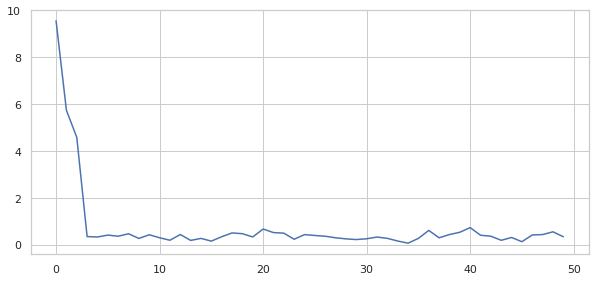

In [ ]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

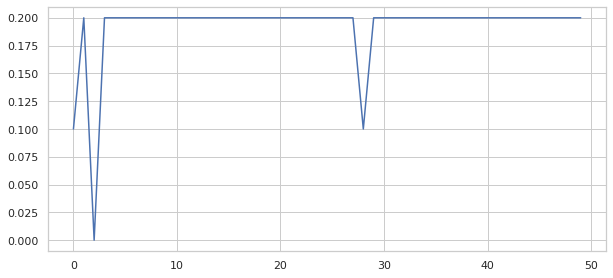

In [ ]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### Metric: MAE

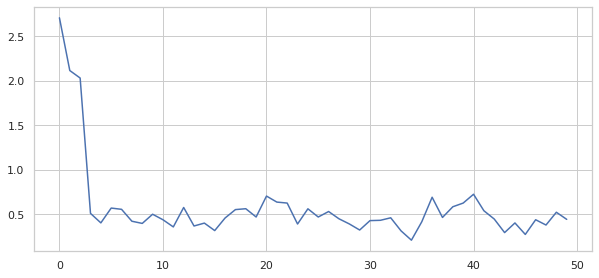

In [ ]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

### Build the Architecture (SIAMESE)

In [73]:
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def getBiLSTMModel() :
  left_input = Input(new_embedded_question_np[0].shape)
  right_input = Input(answers_train_embedded[0].shape)

  bilstm_layer = Bidirectional(LSTM(32, return_sequences= True, dropout= 0.3, recurrent_dropout= 0.3))
  flatten_layer = Flatten()
  dropout_layer = Dropout(0.3)

  question_encoding = dropout_layer(flatten_layer(bilstm_layer(left_input)))
  answer_encoding = dropout_layer(flatten_layer(bilstm_layer(right_input)))

  output_model = concatenate([question_encoding, answer_encoding])
  # output_model = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([question_encoding, answer_encoding])
  output_model = Dense(1, activation='relu')(output_model)

  model = Model(inputs=[left_input, right_input], outputs=[output_model])

  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['accuracy', 'mae'])
  model.summary()

  return model

### Train the Model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 41, 768)]    0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 41, 768)]    0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 41, 64)      205056      ['input_7[0][0]',                
 )                                                                'input_8[0][0]']                
                                                                                                  
 flatten_3 (Flatten)            (None, 2624)         0           ['bidirectional_3[0][0]',  

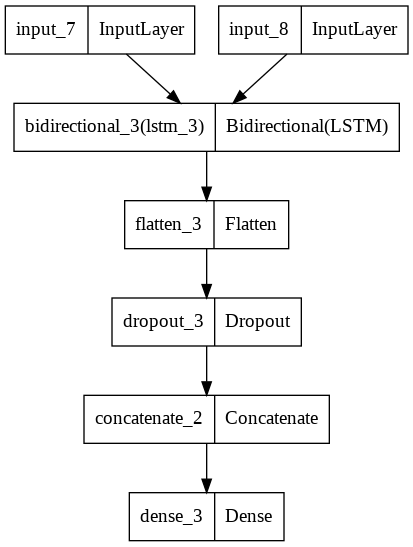

In [77]:
# concatenation
bi_lstm_model = getBiLSTMModel()
tf.keras.utils.plot_model(bi_lstm_model, to_file='my_model.png')

In [78]:
history = bi_lstm_model.fit([new_embedded_question_np, answers_train_embedded],
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 10.7295 - accuracy: 0.0000e+00 - mae: 2.9457
Epoch 2/50
1/1 [==============================] - 0s 211ms/step - loss: 3.2507 - accuracy: 0.2000 - mae: 1.6228
Epoch 3/50
1/1 [==============================] - 0s 203ms/step - loss: 2.7549 - accuracy: 0.2000 - mae: 1.4053
Epoch 4/50
1/1 [==============================] - 0s 216ms/step - loss: 3.2372 - accuracy: 0.2000 - mae: 1.5298
Epoch 5/50
1/1 [==============================] - 0s 202ms/step - loss: 0.9613 - accuracy: 0.2000 - mae: 0.8568
Epoch 6/50
1/1 [==============================] - 0s 200ms/step - loss: 0.7388 - accuracy: 0.2000 - mae: 0.6594
Epoch 7/50
1/1 [==============================] - 0s 232ms/step - loss: 0.4166 - accuracy: 0.2000 - mae: 0.5833
Epoch 8/50
1/1 [==============================] - 0s 196ms/step - loss: 0.2409 - accuracy: 0.2000 - mae: 0.4097
Epoch 9/50
1/1 [==============================] - 0s 219ms/step - loss: 0.9630 - accuracy: 0.2000 - 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 41, 768)]    0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 41, 768)]    0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 41, 64)      205056      ['input_5[0][0]',                
 )                                                                'input_6[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 2624)         0           ['bidirectional_2[0][0]',  

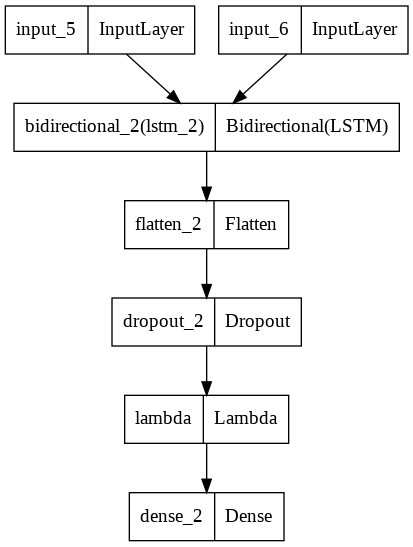

In [71]:
# cosine similarity
bi_lstm_model = getBiLSTMModel()
tf.keras.utils.plot_model(bi_lstm_model, to_file='my_model.png')

In [72]:
history = bi_lstm_model.fit([new_embedded_question_np, answers_train_embedded],
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 13s 13s/step - loss: 10.9992 - accuracy: 0.0000e+00 - mae: 2.9999
Epoch 2/50
1/1 [==============================] - 0s 222ms/step - loss: 10.9927 - accuracy: 0.0000e+00 - mae: 2.9988
Epoch 3/50
1/1 [==============================] - 0s 205ms/step - loss: 10.9864 - accuracy: 0.0000e+00 - mae: 2.9977
Epoch 4/50
1/1 [==============================] - 0s 220ms/step - loss: 10.9802 - accuracy: 0.0000e+00 - mae: 2.9967
Epoch 5/50
1/1 [==============================] - 0s 217ms/step - loss: 10.9740 - accuracy: 0.0000e+00 - mae: 2.9957
Epoch 6/50
1/1 [==============================] - 0s 217ms/step - loss: 10.9680 - accuracy: 0.0000e+00 - mae: 2.9947
Epoch 7/50
1/1 [==============================] - 0s 208ms/step - loss: 10.9619 - accuracy: 0.0000e+00 - mae: 2.9936
Epoch 8/50
1/1 [==============================] - 0s 204ms/step - loss: 10.9559 - accuracy: 0.0000e+00 - mae: 2.9926
Epoch 9/50
1/1 [==============================] - 0s 209ms/step -

### Visualization

#### Loss

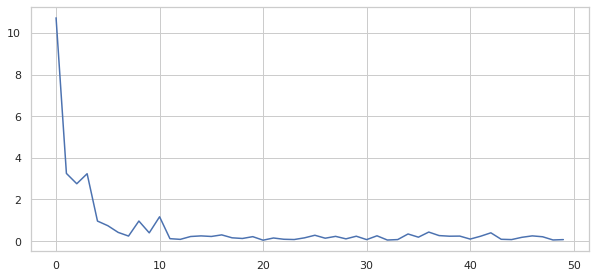

In [79]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

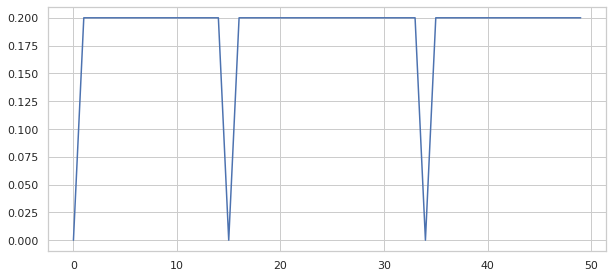

In [80]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### Metric: MAE

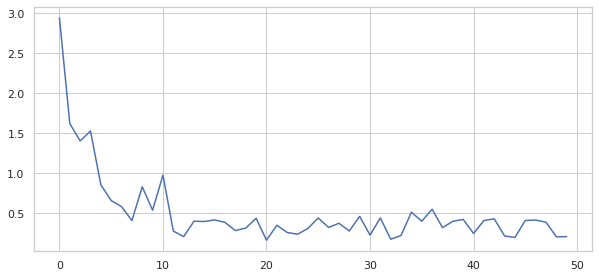

In [81]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

## CNN-LSTM
[https://github.com/mankadronit/Automated-Essay--Scoring](https://github.com/mankadronit/Automated-Essay--Scoring)

### Build the Architecture

In [109]:
from tensorflow.keras.layers import Conv1D, Conv2D

def getCNNLSTMModel() :
  left_input = Input(new_embedded_question_np[0].shape)
  right_input = Input(answers_train_embedded[0].shape)
  
  conv_layer = Conv1D(filters=64, kernel_size=3, padding='same', strides=1)
  lstm_layer = LSTM(128, dropout=0.4, recurrent_dropout=0.4, return_sequences=False)
  dropout_layer = Dropout(0.4)

  question_encoding = dropout_layer(lstm_layer(conv_layer(left_input)))
  answer_encoding = dropout_layer(lstm_layer(conv_layer(right_input)))

  # output_model = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([question_encoding, answer_encoding])
  output_model = concatenate([question_encoding, answer_encoding])
  output_model = Dense(1, activation='relu')(output_model)

  model = Model(inputs=[left_input, right_input], outputs=[output_model])

  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['accuracy', 'mae'])
  model.summary()

  return model

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 41, 64)       147520      ['input_23[0][0]',               
                                                                  'input_24[0][0]']               
                                                                                                  
 lstm_8 (LSTM)                  (None, 128)          98816       ['conv1d_2[0][0]',         

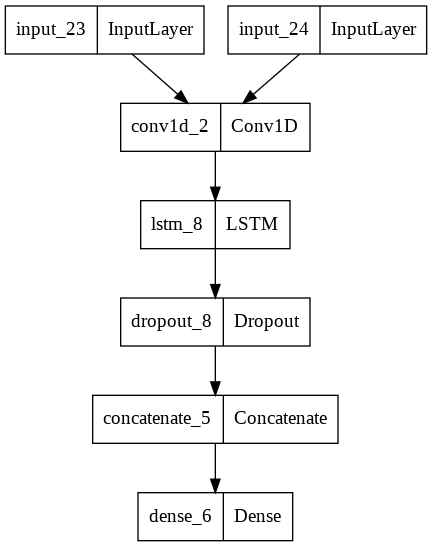

In [110]:
cnn_lstm_model = getCNNLSTMModel()
tf.keras.utils.plot_model(cnn_lstm_model, to_file='my_model.png')

### Train the Model

In [111]:
history = cnn_lstm_model.fit([new_embedded_question_np, answers_train_embedded],
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 9.4740 - accuracy: 0.0000e+00 - mae: 2.7128
Epoch 2/50
1/1 [==============================] - 0s 179ms/step - loss: 4.2112 - accuracy: 0.2000 - mae: 1.7206
Epoch 3/50
1/1 [==============================] - 0s 195ms/step - loss: 3.0904 - accuracy: 0.2000 - mae: 1.4718
Epoch 4/50
1/1 [==============================] - 0s 189ms/step - loss: 2.7416 - accuracy: 0.2000 - mae: 1.2976
Epoch 5/50
1/1 [==============================] - 0s 182ms/step - loss: 2.2385 - accuracy: 0.2000 - mae: 1.1981
Epoch 6/50
1/1 [==============================] - 0s 183ms/step - loss: 1.9167 - accuracy: 0.2000 - mae: 1.2721
Epoch 7/50
1/1 [==============================] - 0s 185ms/step - loss: 0.4887 - accuracy: 0.2000 - mae: 0.5746
Epoch 8/50
1/1 [==============================] - 0s 180ms/step - loss: 0.4252 - accuracy: 0.2000 - mae: 0.5802
Epoch 9/50
1/1 [==============================] - 0s 193ms/step - loss: 1.2023 - accuracy: 0.2000 - mae

### Visualization

#### Loss

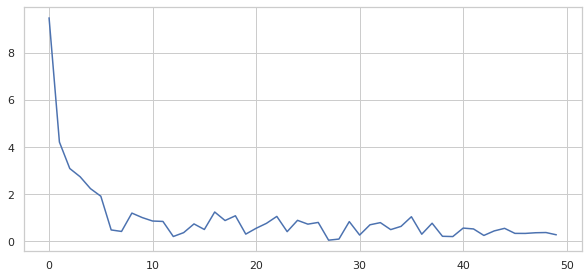

In [112]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

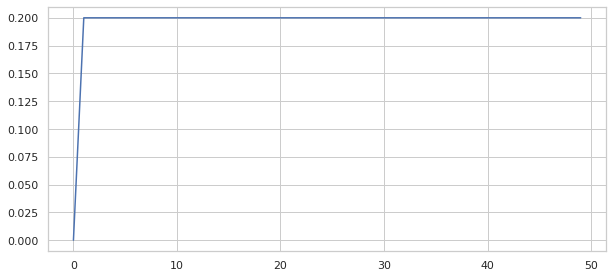

In [113]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### Metric: MAE

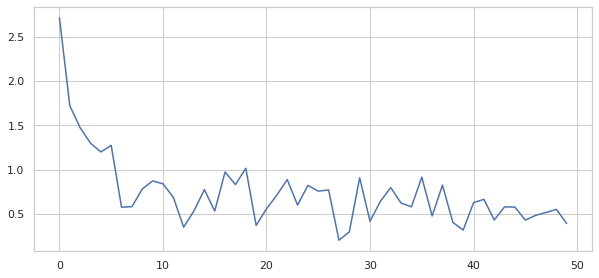

In [114]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

#### Predict Data

In [115]:
id_answers_final = []
for i in idx_test :
  id_answers_final.append(id_answers[i])
  
score_predict = cnn_lstm_model.predict([new_embedded_question_np_test, answers_test_embedded])
score_predict = [float(i[0]) for i in score_predict]
score_int = [round(i) for i in score_predict]
# actual_labels = [df_train.iloc[i]['LABEL'] for i in idx_test]
df_final = pd.DataFrame({'id_mahasiswa': id_answers_final, 'answers': answers_test, 'score': score_predict, 'score (rounded)': score_int})
df_final.head()

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",4.354525,4
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,4.404747,4
2,19,merasa aneh,1.279888,1
3,5,akan terganggu dengan kesehatanya karena merek...,3.186644,3
4,6,Mereka tidak akan di hormati oleh orang layakn...,3.339585,3


## 2-Layer LSTM
[https://www.kaggle.com/soumya9977/autograding-using-lstm-tf-keras](https://www.kaggle.com/soumya9977/autograding-using-lstm-tf-keras)

### Build the Architecture

In [128]:
def get2LayerLSTMModel() :
  left_input = Input(new_embedded_question_np[0].shape)
  right_input = Input(answers_train_embedded[0].shape)
  
  lstm_layer = LSTM(300, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)
  lstm_layer_2 = LSTM(64, recurrent_dropout=0.4)
  dropout_layer = Dropout(0.5)

  question_encoding = dropout_layer(lstm_layer_2(lstm_layer(left_input)))
  answer_encoding = dropout_layer(lstm_layer_2(lstm_layer(right_input)))

  # output_model = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([question_encoding, answer_encoding])
  output_model = concatenate([question_encoding, answer_encoding])
  output_model = Dense(1, activation='relu')(output_model)

  model = Model(inputs=[left_input, right_input], outputs=[output_model])

  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['accuracy', 'mae'])
  model.summary()

  return model

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 lstm_23 (LSTM)                 (None, 41, 300)      1282800     ['input_39[0][0]',               
                                                                  'input_40[0][0]']               
                                                                                                  
 lstm_24 (LSTM)                 (None, 64)           93440       ['lstm_23[0][0]',          

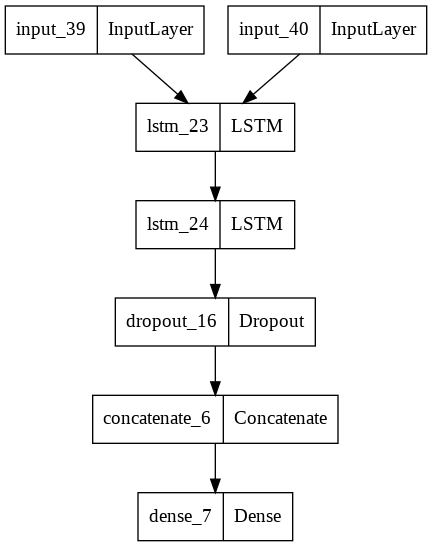

In [129]:
twolayer_lstm_model = get2LayerLSTMModel()
tf.keras.utils.plot_model(twolayer_lstm_model, to_file='my_model.png')

### Train the Model

In [130]:
history = twolayer_lstm_model.fit([new_embedded_question_np, answers_train_embedded],
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 12s 12s/step - loss: 11.0000 - accuracy: 0.0000e+00 - mae: 3.0000
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 9.8892 - accuracy: 0.0000e+00 - mae: 2.7047
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 4.1060 - accuracy: 0.2000 - mae: 1.8109
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 3.2709 - accuracy: 0.2000 - mae: 1.5705
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 3.0468 - accuracy: 0.2000 - mae: 1.5554
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 1.5874 - accuracy: 0.2000 - mae: 1.1310
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 1.2504 - accuracy: 0.2000 - mae: 1.0404
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 1.1602 - accuracy: 0.2000 - mae: 1.0396
Epoch 9/50
1/1 [==============================] - 1s 1s/step - loss: 1.4319 - accuracy: 0.2000 - mae: 1.1158
Epoch 10

### Visualization

#### Loss

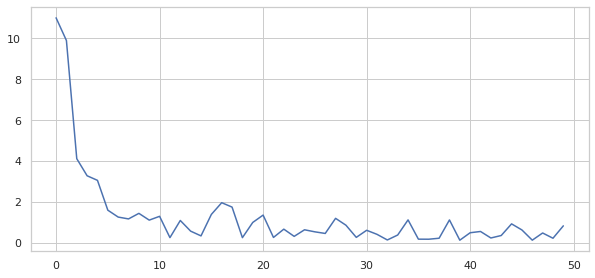

In [131]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

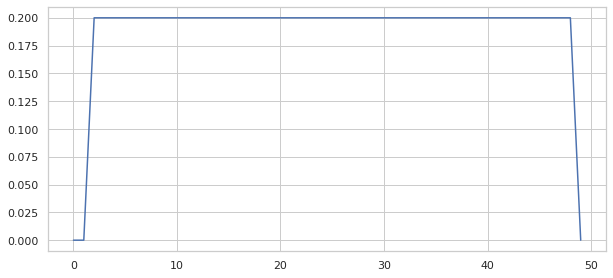

In [132]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### Metric: MAE

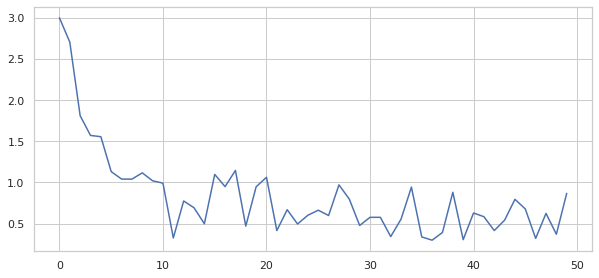

In [133]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

#### Predict Data

In [134]:
id_answers_final = []
for i in idx_test :
  id_answers_final.append(id_answers[i])
  
score_predict = twolayer_lstm_model.predict([new_embedded_question_np_test, answers_test_embedded])
score_predict = [float(i[0]) for i in score_predict]
score_int = [round(i) for i in score_predict]
# actual_labels = [df_train.iloc[i]['LABEL'] for i in idx_test]
df_final = pd.DataFrame({'id_mahasiswa': id_answers_final, 'answers': answers_test, 'score': score_predict, 'score (rounded)': score_int})
df_final.head()

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",3.669428,4
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,3.632538,4
2,19,merasa aneh,0.753331,1
3,5,akan terganggu dengan kesehatanya karena merek...,2.111804,2
4,6,Mereka tidak akan di hormati oleh orang layakn...,2.256724,2


## 2 Layer Bi-LSTM
[https://github.com/Gaurav-Pande/AES_DL](https://github.com/Gaurav-Pande/AES_DL)

### Build the Architecture

In [146]:
def get2LayerBiLSTMModel() :
  left_input = Input(new_embedded_question_np[0].shape)
  right_input = Input(answers_train_embedded[0].shape)

  bilstm_layer = Bidirectional(LSTM(300, return_sequences=True , dropout=0.4, recurrent_dropout=0.4))
  bilstm_layer_2 = Bidirectional(LSTM(100, recurrent_dropout=0.4))
  dropout_layer = Dropout(0.5)

  question_encoding = dropout_layer(bilstm_layer_2(bilstm_layer(left_input)))
  answer_encoding = dropout_layer(bilstm_layer_2(bilstm_layer(right_input)))

  # output_model = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([question_encoding, answer_encoding])
  output_model = concatenate([question_encoding, answer_encoding])
  output_model = Dense(1, activation='relu')(output_model)

  model = Model(inputs=[left_input, right_input], outputs=[output_model])

  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['accuracy', 'mae'])
  model.summary()

  return model

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 41, 600)     2565600     ['input_47[0][0]',               
 )                                                                'input_48[0][0]']               
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 200)         560800      ['bidirectional_8[0][0]', 

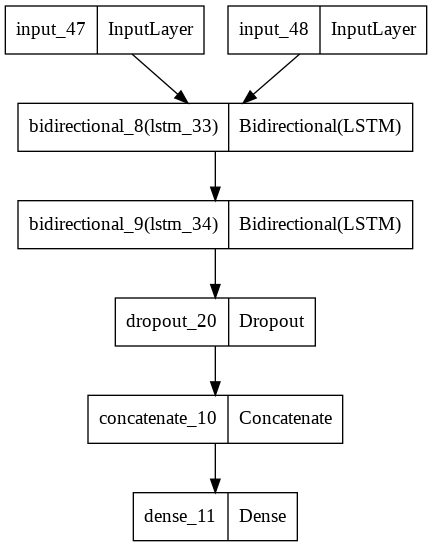

In [147]:
twolayer_bilstm_model = get2LayerBiLSTMModel()
tf.keras.utils.plot_model(twolayer_bilstm_model, to_file='my_model.png')

### Train the Model

In [148]:
history = twolayer_bilstm_model.fit([new_embedded_question_np, answers_train_embedded],
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 27s 27s/step - loss: 11.0000 - accuracy: 0.0000e+00 - mae: 3.0000
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 11.0000 - accuracy: 0.0000e+00 - mae: 3.0000
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 10.8148 - accuracy: 0.0000e+00 - mae: 2.9765
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 4.5357 - accuracy: 0.2000 - mae: 1.7399
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 2.5948 - accuracy: 0.2000 - mae: 1.4963
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 1.2665 - accuracy: 0.2000 - mae: 1.0510
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.3981 - accuracy: 0.2000 - mae: 0.5519
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 0.3597 - accuracy: 0.2000 - mae: 0.5200
Epoch 9/50
1/1 [==============================] - 2s 2s/step - loss: 0.2897 - accuracy: 0.2000 - mae: 0.4430
Ep

### Visualization

#### Loss

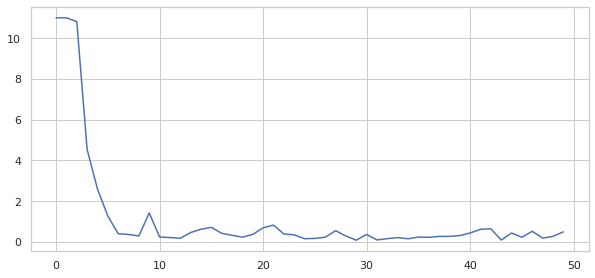

In [149]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

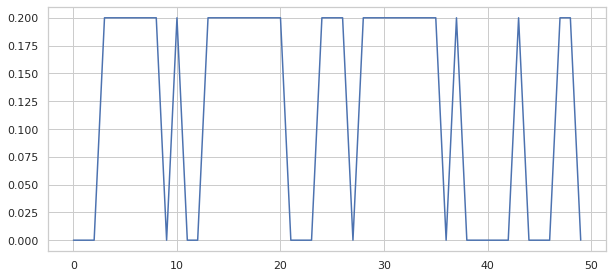

In [150]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### Metric: MAE

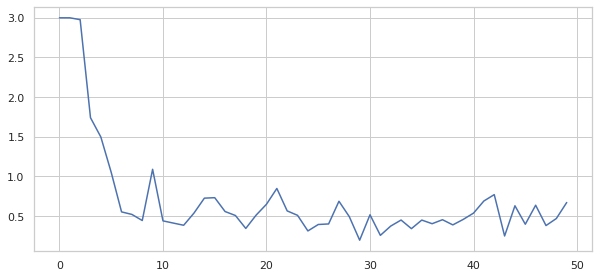

In [151]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

#### Predict Data

In [152]:
id_answers_final = []
for i in idx_test :
  id_answers_final.append(id_answers[i])
  
score_predict = twolayer_bilstm_model.predict([new_embedded_question_np_test, answers_test_embedded])
score_predict = [float(i[0]) for i in score_predict]
score_int = [round(i) for i in score_predict]
# actual_labels = [df_train.iloc[i]['LABEL'] for i in idx_test]
df_final = pd.DataFrame({'id_mahasiswa': id_answers_final, 'answers': answers_test, 'score': score_predict, 'score (rounded)': score_int})
df_final.head()

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",3.816974,4
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,3.892216,4
2,19,merasa aneh,1.014795,1
3,5,akan terganggu dengan kesehatanya karena merek...,2.370853,2
4,6,Mereka tidak akan di hormati oleh orang layakn...,2.664500,3


## Bi-LSTM with Attention

### Define Attention Layer

In [190]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

### Build the Architecture

In [191]:
def getBiLSTMwithAttentionModel() :
  left_input = Input(new_embedded_question_np[0].shape)
  right_input = Input(answers_train_embedded[0].shape)

  bilstm_layer = Bidirectional(LSTM(300, return_sequences=True , dropout=0.4, recurrent_dropout=0.4))
  attention_layer = Attention(return_sequences= False)
  # bilstm_layer_2 = Bidirectional(LSTM(100, recurrent_dropout=0.4))
  dropout_layer = Dropout(0.5)

  question_encoding = dropout_layer(attention_layer(bilstm_layer(left_input)))
  answer_encoding = dropout_layer(attention_layer(bilstm_layer(right_input)))

  # output_model = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([question_encoding, answer_encoding])
  output_model = concatenate([question_encoding, answer_encoding])
  output_model = Dense(1, activation='relu')(output_model)

  model = Model(inputs=[left_input, right_input], outputs=[output_model])

  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['accuracy', 'mae'])
  model.summary()

  return model

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 input_62 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 41, 600)     2565600     ['input_61[0][0]',               
 l)                                                               'input_62[0][0]']               
                                                                                                  
 attention_3 (Attention)        (None, 600)          641         ['bidirectional_14[0][0]',

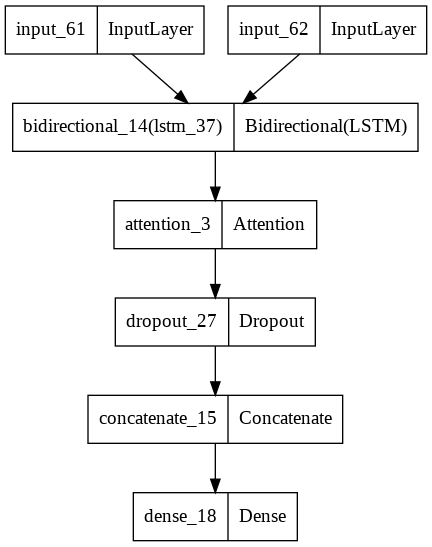

In [192]:
bilstm_with_attention_model = getBiLSTMwithAttentionModel()
tf.keras.utils.plot_model(bilstm_with_attention_model, to_file='my_model.png')

### Train the Model

In [193]:
history = bilstm_with_attention_model.fit([new_embedded_question_np, answers_train_embedded],
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 16s 16s/step - loss: 9.6570 - accuracy: 0.0000e+00 - mae: 2.6429
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 9.1252 - accuracy: 0.2000 - mae: 2.6267
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 2.8350 - accuracy: 0.2000 - mae: 1.5914
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.5639 - accuracy: 0.2000 - mae: 0.6154
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 0.9758 - accuracy: 0.2000 - mae: 0.8706
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 1.1146 - accuracy: 0.0000e+00 - mae: 0.9732
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.1162 - accuracy: 0.2000 - mae: 0.2668
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 0.5900 - accuracy: 0.2000 - mae: 0.6087
Epoch 9/50
1/1 [==============================] - 2s 2s/step - loss: 1.1051 - accuracy: 0.2000 - mae: 0.9950
Epoch 10/

### Visualization

#### Loss

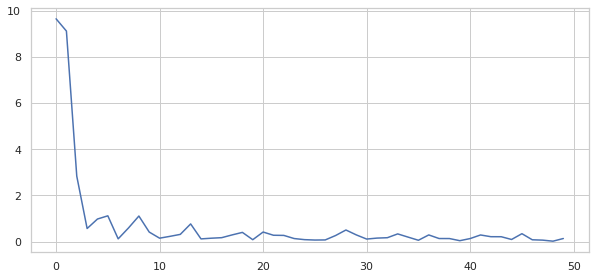

In [194]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

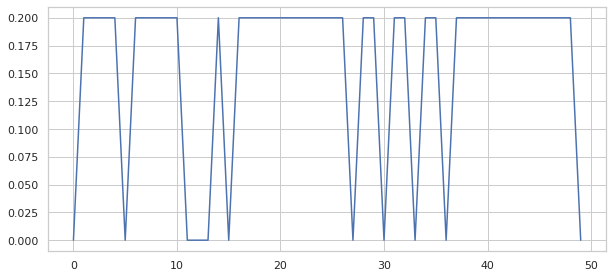

In [195]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### Metric: MAE

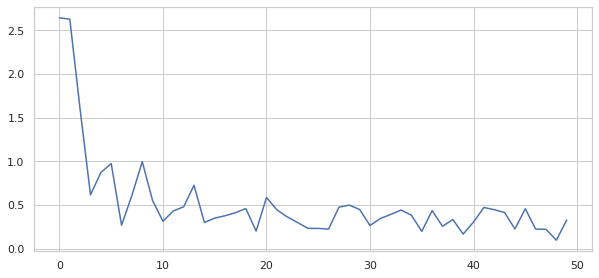

In [196]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

#### Predict Data

In [197]:
id_answers_final = []
for i in idx_test :
  id_answers_final.append(id_answers[i])
  
score_predict = bilstm_with_attention_model.predict([new_embedded_question_np_test, answers_test_embedded])
score_predict = [float(i[0]) for i in score_predict]
score_int = [round(i) for i in score_predict]
# actual_labels = [df_train.iloc[i]['LABEL'] for i in idx_test]
df_final = pd.DataFrame({'id_mahasiswa': id_answers_final, 'answers': answers_test, 'score': score_predict, 'score (rounded)': score_int})
df_final.head()

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",3.816323,4
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,3.988462,4
2,19,merasa aneh,0.275411,0
3,5,akan terganggu dengan kesehatanya karena merek...,2.630658,3
4,6,Mereka tidak akan di hormati oleh orang layakn...,2.712398,3


##Bi-GRU

### Build the Architecture

In [171]:
def getBiGRUModel() :
  left_input = Input(new_embedded_question_np[0].shape)
  right_input = Input(answers_train_embedded[0].shape)

  bigru_layer = Bidirectional(GRU(300, return_sequences=True , dropout=0.4, recurrent_dropout=0.4))
  dropout_layer = Dropout(0.5)

  question_encoding = dropout_layer(bigru_layer(left_input))
  answer_encoding = dropout_layer(bigru_layer(right_input))

  # output_model = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([question_encoding, answer_encoding])
  output_model = concatenate([question_encoding, answer_encoding])
  output_model = Dense(1, activation='relu')(output_model)

  model = Model(inputs=[left_input, right_input], outputs=[output_model])

  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['accuracy', 'mae'])
  model.summary()

  return model

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 41, 600)     1926000     ['input_53[0][0]',               
 l)                                                               'input_54[0][0]']               
                                                                                                  
 dropout_23 (Dropout)           (None, 41, 600)      0           ['bidirectional_12[0][0]',

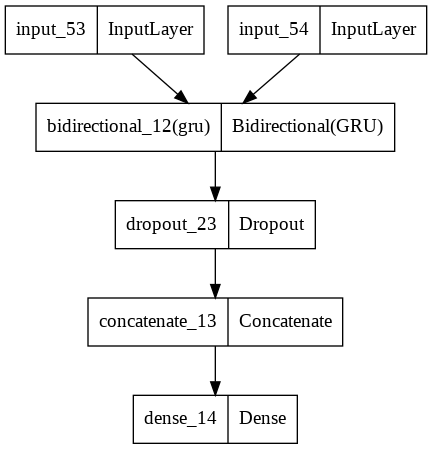

In [172]:
bigru_model = getBiGRUModel()
tf.keras.utils.plot_model(bigru_model, to_file='my_model.png')

### Train the Model

In [173]:
history = bigru_model.fit([new_embedded_question_np, answers_train_embedded],
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 13s 13s/step - loss: 10.3525 - accuracy: 0.0234 - mae: 2.8781
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 13.5233 - accuracy: 0.2000 - mae: 3.0193
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 3.5775 - accuracy: 0.1912 - mae: 1.5467
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 6.9581 - accuracy: 0.1141 - mae: 2.2141
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 6.9083 - accuracy: 0.1073 - mae: 2.1994
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 6.7170 - accuracy: 0.1083 - mae: 2.1614
Epoch 7/50
1/1 [==============================] - 4s 4s/step - loss: 6.9947 - accuracy: 0.1132 - mae: 2.2188
Epoch 8/50
1/1 [==============================] - 4s 4s/step - loss: 7.1855 - accuracy: 0.1132 - mae: 2.2551
Epoch 9/50
1/1 [==============================] - 4s 4s/step - loss: 6.5192 - accuracy: 0.1171 - mae: 2.1249
Epoch 10/50
1/1

### Visualization

#### Loss

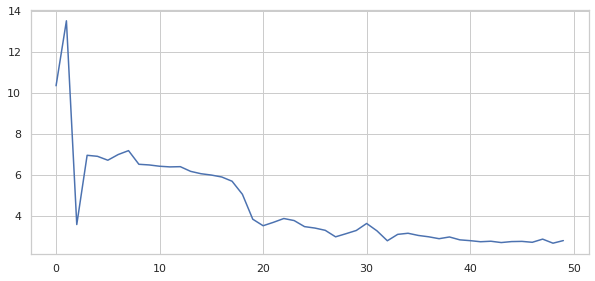

In [174]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

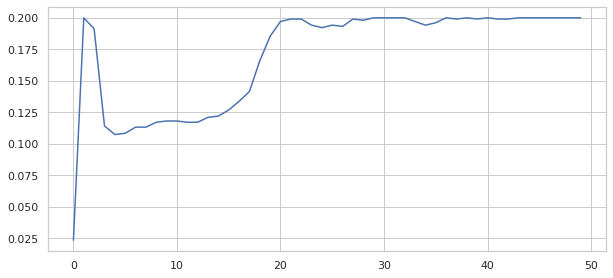

In [175]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### Metric: MAE

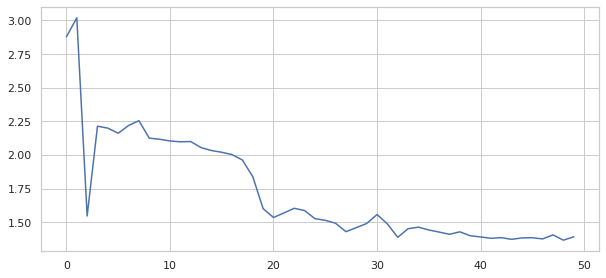

In [176]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

#### Predict Data

In [177]:
id_answers_final = []
for i in idx_test :
  id_answers_final.append(id_answers[i])
  
score_predict = bigru_model.predict([new_embedded_question_np_test, answers_test_embedded])
score_predict = [float(i[0]) for i in score_predict]
score_int = [round(i) for i in score_predict]
# actual_labels = [df_train.iloc[i]['LABEL'] for i in idx_test]
df_final = pd.DataFrame({'id_mahasiswa': id_answers_final, 'answers': answers_test, 'score': score_predict, 'score (rounded)': score_int})
df_final.head()

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",2.780023,3
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,3.205181,3
2,19,merasa aneh,3.084561,3
3,5,akan terganggu dengan kesehatanya karena merek...,3.413317,3
4,6,Mereka tidak akan di hormati oleh orang layakn...,2.811948,3


In [178]:
df_final

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",2.780023,3
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,3.205181,3
2,19,merasa aneh,3.084561,3
3,5,akan terganggu dengan kesehatanya karena merek...,3.413317,3
4,6,Mereka tidak akan di hormati oleh orang layakn...,2.811948,3
5,14,Pengungsi iklim ini orang-orang yang terpaksa ...,3.397792,3
6,47,Mereka harus bisa beradaptasi dengan lingkunga...,3.077784,3
7,25,orang-orang yang trpaksa meninggalkan komunita...,3.206037,3
8,43,kehilangan segalanya,3.185368,3
9,17,Pengungsi iklim adalah orang-orang yang terpak...,3.275819,3


##Bi-GRU with Attention

### Define Attention Layer

In [179]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

### Build the Architecture

In [180]:
def getBiGRUwithAttentionModel() :
  left_input = Input(new_embedded_question_np[0].shape)
  right_input = Input(answers_train_embedded[0].shape)

  bigru_layer = Bidirectional(GRU(300, return_sequences=True , dropout=0.4, recurrent_dropout=0.4))
  attention_layer = Attention(return_sequences= False)
  # bilstm_layer_2 = Bidirectional(LSTM(100, recurrent_dropout=0.4))
  dropout_layer = Dropout(0.5)

  question_encoding = dropout_layer(attention_layer(bigru_layer(left_input)))
  answer_encoding = dropout_layer(attention_layer(bigru_layer(right_input)))

  # output_model = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([question_encoding, answer_encoding])
  output_model = concatenate([question_encoding, answer_encoding])
  output_model = Dense(1, activation='relu')(output_model)

  model = Model(inputs=[left_input, right_input], outputs=[output_model])

  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['accuracy', 'mae'])
  model.summary()

  return model

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 input_56 (InputLayer)          [(None, 41, 768)]    0           []                               
                                                                                                  
 bidirectional_13 (Bidirectiona  (None, 41, 600)     1926000     ['input_55[0][0]',               
 l)                                                               'input_56[0][0]']               
                                                                                                  
 attention_2 (Attention)        (None, 600)          641         ['bidirectional_13[0][0]',

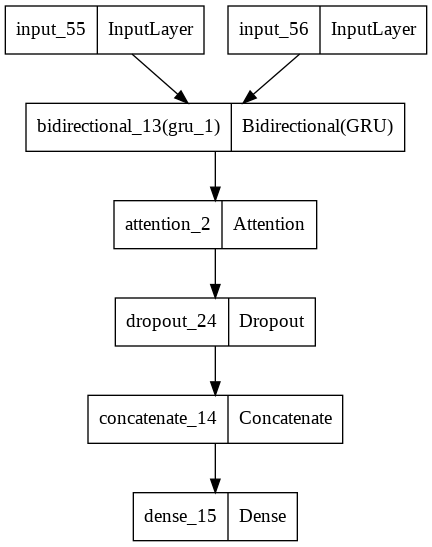

In [181]:
bigruwithattention_model = getBiGRUwithAttentionModel()
tf.keras.utils.plot_model(bigruwithattention_model, to_file='my_model.png')

### Train the Model

In [182]:
history = bigruwithattention_model.fit([new_embedded_question_np, answers_train_embedded],
                    scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 13s 13s/step - loss: 5.2950 - accuracy: 0.2000 - mae: 1.8951
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 9.2799 - accuracy: 0.2000 - mae: 2.6154
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.8760 - accuracy: 0.2000 - mae: 0.7613
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 3.2266 - accuracy: 0.0000e+00 - mae: 1.6125
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 3.2157 - accuracy: 0.0000e+00 - mae: 1.5978
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 2.9015 - accuracy: 0.0000e+00 - mae: 1.3506
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 2.8317 - accuracy: 0.0000e+00 - mae: 1.3122
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 2.8129 - accuracy: 0.0000e+00 - mae: 1.2692
Epoch 9/50
1/1 [==============================] - 2s 2s/step - loss: 2.9834 - accuracy: 0.0000e+00 - mae: 

### Visualization

#### Loss

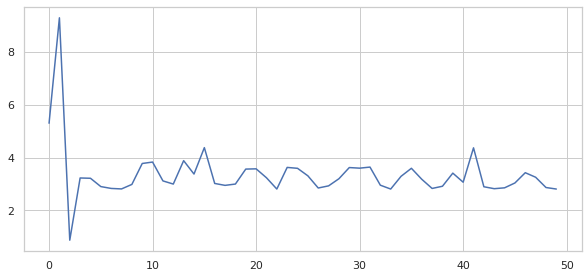

In [183]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

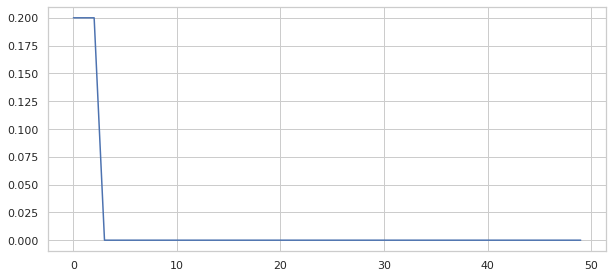

In [184]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### Metric: MAE

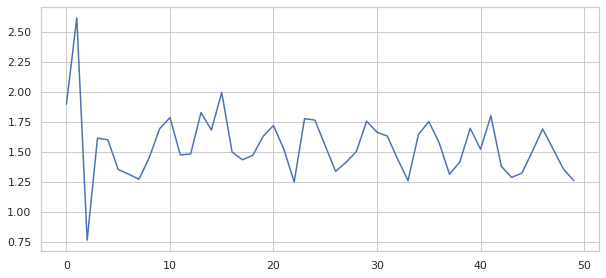

In [185]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

#### Predict Data

In [186]:
id_answers_final = []
for i in idx_test :
  id_answers_final.append(id_answers[i])
  
score_predict = bigruwithattention_model.predict([new_embedded_question_np_test, answers_test_embedded])
score_predict = [float(i[0]) for i in score_predict]
score_int = [round(i) for i in score_predict]
# actual_labels = [df_train.iloc[i]['LABEL'] for i in idx_test]
df_final = pd.DataFrame({'id_mahasiswa': id_answers_final, 'answers': answers_test, 'score': score_predict, 'score (rounded)': score_int})
df_final.head()

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",3.100657,3
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,4.040605,4
2,19,merasa aneh,0.000000,0
3,5,akan terganggu dengan kesehatanya karena merek...,0.000000,0
4,6,Mereka tidak akan di hormati oleh orang layakn...,0.000000,0


# Save Data

### Convert Data to DataFrame

In [134]:
id_answers_final = []
for i in idx_test :
  id_answers_final.append(id_answers[i])

In [135]:
answers_test_embedded.shape

(45, 41, 768)

In [136]:
score_predict = cnn_lstm_model.predict([new_embedded_question_np_test, answers_test_embedded])
score_predict = [float(i[0]) for i in score_predict]
score_int = [round(i) for i in score_predict]
# actual_labels = [df_train.iloc[i]['LABEL'] for i in idx_test]
df_final = pd.DataFrame({'id_mahasiswa': id_answers_final, 'answers': answers_test, 'score': score_predict, 'score (rounded)': score_int})
df_final.head()

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",3.852704,4
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,3.923099,4
2,19,merasa aneh,3.267407,3
3,5,akan terganggu dengan kesehatanya karena merek...,3.522892,4
4,6,Mereka tidak akan di hormati oleh orang layakn...,3.694484,4


In [137]:
df_final

,id_mahasiswa,answers,score,score (rounded)
0,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",3.852704,4
1,37,Tantangan pengungsi iklim adalah lahan pekerja...,3.923099,4
2,19,merasa aneh,3.267407,3
3,5,akan terganggu dengan kesehatanya karena merek...,3.522892,4
4,6,Mereka tidak akan di hormati oleh orang layakn...,3.694484,4
5,14,Pengungsi iklim ini orang-orang yang terpaksa ...,3.607259,4
6,47,Mereka harus bisa beradaptasi dengan lingkunga...,3.404097,3
7,25,orang-orang yang trpaksa meninggalkan komunita...,3.550229,4
8,43,kehilangan segalanya,3.311882,3
9,17,Pengungsi iklim adalah orang-orang yang terpak...,3.540247,4


## Save to CSV

### Direct Save

In [64]:
df_final.to_excel("scoring_result.xlsx", index = False)

### Auto Adjust Column Width

In [65]:
pip install xlsxwriter

     |████████████████████████████████| 149 kB 4.4 MB/s 


In [66]:
filename = 'scoring_result.xlsx'
dfs = {'df_final': df_final}

writer = pd.ExcelWriter(filename, engine='xlsxwriter')
for sheetname, df in dfs.items():  # loop through `dict` of dataframes
    df.to_excel(writer, sheet_name=sheetname, index = False)  # send df to writer
    worksheet = writer.sheets[sheetname]  # pull worksheet object
    for idx, col in enumerate(df):  # loop through all columns
        series = df[col]
        max_len = max((
            series.astype(str).map(len).max(),  # len of largest item
            len(str(series.name))  # len of column name/header
            )) + 1  # adding a little extra space
        worksheet.set_column(idx, idx, max_len)  # set column width
writer.save()